# Importing the necessary libraries

In [90]:
import numpy as np
import zipfile as zf
import json
import time
import scipy.sparse as sps
from scipy import random
from sklearn.preprocessing import normalize
from itertools import count
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Necessary parameters for calculation

* $\mathbf{fileName}$: Name of the data file.
* $\mathbf{tagCutoff}$: Minimum tag relation between a tag and a track for them to be related.
* $\mathbf{K}$: Amount of clusters.
* $\mathbf{eigCalTol}$: Eigenvector calculation tolerance. Please don't edit this unless you have a strong computer. With tolerance 0, it takes my laptop over 20 hours to calculate the 10 eigenvectors of a 455.000 x 455.000 sparse matrix.
* $\mathbf{dsFrac}$: What fraction of the dataset should be loaded. Please be careful with this. Too much of data would lead to a lot of time spent on eigenvector calculation.

In [2]:
fileName = 'lastfm_test.zip'
tagCutoff = 50
K = 10
eigCalTol = 1e-2
dsFrac = 1.0

# Reading the Dataset

In [13]:
begin = time.clock()

Dupls = []
simD = []
tagD = []
trkToIndex = {}
tagToIndex = {}
file = zf.ZipFile(fileName)
trkCounter = count()
tagCounter = count()

maxI = np.floor(len(file.filelist)*dsFrac).astype(np.int)

for i in range(maxI):
    
    if(i%(maxI//10) == 0):
        print(round(100 * i / maxI), " % of data is loaded.")
    
    if(file.filelist[i].filename.endswith('.json')):
        fCont = file.read(file.filelist[i]).decode("utf-8")
        jCont = json.loads(fCont)
        
        sims = np.array(jCont['similars'])
        tags = np.array(jCont['tags'])
        tName = jCont['track_id']
        
        if(len(sims) > 0):

            if(tName in trkToIndex):
                trkIndex = trkToIndex[tName]
            else:
                trkIndex = next(trkCounter)
                trkToIndex[tName] = trkIndex

            prevTrk = []

            for s in sims:
                similarity = float(s[1])
                #Some values are buggy. IE: There are values as large as 3000. Below code is to fix that
                while(similarity > 1.0):
                    similarity /= 10
                    
                tName2 = s[0]

                if(tName2 not in prevTrk):
                    if(tName2 in trkToIndex):
                        trkIndex2 = trkToIndex[tName2]
                    else:
                        trkIndex2 = next(trkCounter)
                        trkToIndex[tName2] = trkIndex2

                    simD.append([trkIndex, trkIndex2, similarity])
                    prevTrk.append(tName2)
                    
                    
            for t in tags:
                if(int(t[1]) >= tagCutoff):
                    if(t[0] in tagToIndex):
                        tagId = tagToIndex[t[0]]
                    else:
                        tagId = next(tagCounter)
                        tagToIndex[t[0]] = tagId
                    tagD.append([trkIndex, tagId, 1])
                
file.close()
tagD = np.array(tagD)
simD = np.array(simD)

print("Loading the dataset took ", time.clock() - begin, " seconds.")

0.0  % of data is loaded.
10.0  % of data is loaded.
20.0  % of data is loaded.
30.0  % of data is loaded.
40.0  % of data is loaded.
50.0  % of data is loaded.
60.0  % of data is loaded.
70.0  % of data is loaded.
80.0  % of data is loaded.
90.0  % of data is loaded.
100.0  % of data is loaded.
Loading the dataset took  73.47851666454062  seconds.


# Creating the Tag, L, L_sym matrices

In [81]:
begin = time.clock()

N = len(trkToIndex)

X = tagD[:,0].astype(np.int)
Y = tagD[:,1].astype(np.int)
Z = tagD[:,2].astype(np.int)
tagM = sps.coo_matrix((Z, (X,Y)), shape=(N, len(tagToIndex))).tocsc()

X = simD[:,0].astype(np.int)
Y = simD[:,1].astype(np.int)
Z = simD[:,2].astype(np.float)
W = sps.coo_matrix((Z, (X,Y)), shape=(N, N)).tocsc()
W = (W + W.T + abs(W - W.T))/2

d = np.array(W.sum(0))[0]
D = sps.diags(d).tocsc()
L = D - W

D_isq = sps.diags(np.sqrt(1/d)).tocsc()
L_sym = D_isq.dot(L.dot(D_isq))

#del X, Y, Z, d, D, D_isq
print("Generating the weighted adjacency(W) and Laplacian(L) matrices took ", time.clock() - begin, " seconds.")

Generating the weighted adjacency(W) and Laplacian(L) matrices took  4.471136349973676  seconds.


# Calculating the Answers using L Matrix

In [164]:
begin = time.clock()

print("Applying Spectral Shifting")
[w,v] = sps.linalg.eigsh(L,k=1, tol=eigCalTol)
B = L-sps.diags([w[0] for i in range(N)])
wMax = w[0]

print("Calculating the Constrained Relaxation Answer")
[w,v] = sps.linalg.eigsh(B,k=K, tol=eigCalTol)
H_L_1 = v.copy()

print("Calculating the K-Means Cluster Centers")
H_L_1 = normalize(H_L_1, norm='l1', axis=0)
km = KMeans(n_clusters=K, random_state=0).fit(H_L_1)

print("Assigning each item to its cluster")
clusters = [[] for i in range(K)]
for i in range(N):
    if(i%(N//10) == 0):
        print(round(100 * i / N), " % of data is assigned to its cluster.")
    v_i = H_L_1[i]
    dists = []
    for m in km.cluster_centers_:
        dists.append(np.linalg.norm(m-v_i))
    clusters[np.argmin(np.array(dists))].append(i)

print("Calculating the Hard Answer Assignment")
clS = [len(c) for c in clusters]
h = []
for i in range(K):
    h_t = np.array([np.array(clusters[i]), np.zeros(clS[i])+i, np.ones(clS[i])*1/clS[i]]).T
    if(len(h) == 0):
        h = h_t.copy()
    else:
        h = np.append(h,h_t,axis=0)
H_L_2 = sps.coo_matrix((h[:,2],(h[:,0],h[:,1]))).tocsr()

print("Spectral clustering took ", time.clock()-begin, " seconds")

Applying Spectral Shifting
Calculating the Constrained Relaxation Answer
Calculating the K-Means Cluster Centers
Assigning each item to its cluster
0  % of data is assigned to its cluster.
10  % of data is assigned to its cluster.
20  % of data is assigned to its cluster.
30  % of data is assigned to its cluster.
40  % of data is assigned to its cluster.
50  % of data is assigned to its cluster.
60  % of data is assigned to its cluster.
70  % of data is assigned to its cluster.
80  % of data is assigned to its cluster.
90  % of data is assigned to its cluster.
100  % of data is assigned to its cluster.
Calculating the Hard Answer Assignment
Spectral clustering took  174.70396815622007  seconds


# Results obtained using L matrix

The ratio cut values for Constrained Relaxatio are: 

9.16006478903e-06
7.02622745443e-06
7.4760434942e-06
7.92957083135e-06
8.90097388944e-06
9.85732678572e-06
1.14337585758e-05
1.28203910832e-05
1.41082783312e-05
1.58494243655e-05

The ratio cut values for Hard Assignment are: 

1.73959309049e-05
2.64976935473e-06
1.54663415234e-05
0.00013489594099
5.66206129076e-05
0.000126466587783
0.000115197240422
9.64786893233e-05
0.000120898410954
0.000100077260668


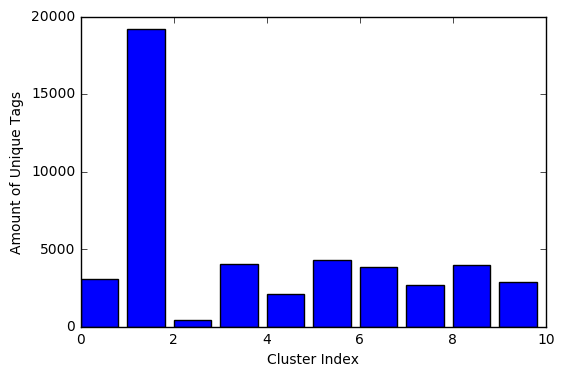

In [152]:
ratCuts_L_1 = H_L_1.T.dot(L_sym.dot(H_L_1)).diagonal()
ratCuts_L_2 = H_L_2.T.dot(L_sym.dot(H_L_2)).diagonal()

print("The ratio cut values for Constrained Relaxatio are: \n")
for r in ratCuts_L_1:
    print(r)

print()

print("The ratio cut values for Hard Assignment are: \n")
for r in ratCuts_L_2:
    print(r)

tagsByCluster = [[] for k in range(K)]

for k in range(K):
    tagsByCluster[k] = len(set(tagM[clusters[k],:].nonzero()[1]))

vplt.bar(range(K),tagsByCluster)
plt.xlabel("Cluster Index")
plt.ylabel("Amount of Unique Tags in a Cluster")
plt.show()

# Calculating the Answers using L_sym Matrix

In [167]:
begin = time.clock()

print("Applying Spectral Shifting")
[w,v] = sps.linalg.eigsh(L_sym,k=1, tol=eigCalTol)
B = L_sym-sps.diags([w[0] for i in range(N)])
wMax = w[0]

print("Calculating the Constrained Relaxation Answer")
[w,v] = sps.linalg.eigsh(B,k=K+1, tol=eigCalTol)
H_L_1 = v[:,1:K+1].copy()

print("Calculating the K-Means Cluster Centers")
H_L_1 = normalize(H_L_1, norm='l1', axis=0)
km = KMeans(n_clusters=K, random_state=0).fit(H_L_1)

print("Assigning each item to its cluster")
clusters = [[] for i in range(K)]
for i in range(N):
    if(i%(N//10) == 0):
        print(round(100 * i / N), " % of data is assigned to its cluster.")
    v_i = H_L_1[i]
    dists = []
    for m in km.cluster_centers_:
        dists.append(np.linalg.norm(m-v_i))
    clusters[np.argmin(np.array(dists))].append(i)

print("Calculating the Hard Answer Assignment")
clS = [len(c) for c in clusters]
h = []
for i in range(K):
    h_t = np.array([np.array(clusters[i]), np.zeros(clS[i])+i, np.ones(clS[i])*1/clS[i]]).T
    if(len(h) == 0):
        h = h_t.copy()
    else:
        h = np.append(h,h_t,axis=0)
H_L_2 = sps.coo_matrix((h[:,2],(h[:,0],h[:,1]))).tocsr()

print("Spectral clustering took ", time.clock()-begin, " seconds")

Applying Spectral Shifting
Calculating the Constrained Relaxation Answer
Calculating the K-Means Cluster Centers
Assigning each item to its cluster
0  % of data is assigned to its cluster.
10  % of data is assigned to its cluster.
20  % of data is assigned to its cluster.
30  % of data is assigned to its cluster.
40  % of data is assigned to its cluster.
50  % of data is assigned to its cluster.
60  % of data is assigned to its cluster.
70  % of data is assigned to its cluster.
80  % of data is assigned to its cluster.
90  % of data is assigned to its cluster.
100  % of data is assigned to its cluster.
Calculating the Hard Answer Assignment
Spectral clustering took  101.58196020040486  seconds


# Results obtained using L_sym matrix

The ratio cut values for Constrained Relaxatio are: 

8.42662940917e-07
3.62976104195e-07
4.09145971807e-07
1.09266075852e-06
1.17852861451e-06
8.68177642972e-07
9.75406418517e-07
1.06159056476e-06
1.49122357571e-06
1.49643798203e-06

The ratio cut values for Hard Assignment are: 

1.28766189819e-06
0.011004696222
0.0984132653878
0.0182287826694
0.00732704937529
0.00304372283993
0.00556928576974
0.00163561877562
0.00159417067536
0.00552664186553


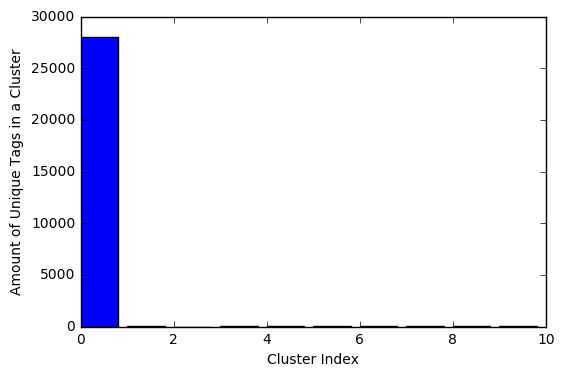

In [163]:
ratCuts_L_1 = H_L_1.T.dot(L_sym.dot(H_L_1)).diagonal()
ratCuts_L_2 = H_L_2.T.dot(L_sym.dot(H_L_2)).diagonal()

print("The ratio cut values for Constrained Relaxatio are: \n")
for r in ratCuts_L_1:
    print(r)

print()

print("The ratio cut values for Hard Assignment are: \n")
for r in ratCuts_L_2:
    print(r)

tagsByCluster = [[] for k in range(K)]

for k in range(K):
    tagsByCluster[k] = len(set(tagM[clusters[k],:].nonzero()[1]))

plt.bar(range(K),tagsByCluster)
plt.xlabel("Cluster Index")
plt.ylabel("Amount of Unique Tags in a Cluster")
plt.show()

# Notes and Conclusions
It seems that when we're using L_sym for clustering, A VERY LARGE portion of the dataset is clustered into a single cluster and when using L matrix, we se a more balanced distribution of tracks per cluster.

That is because regular laplacian matrix L approximates the Ratio-Cut and normalized laplacian matrix approximates Normalized-Cut.

Also naturally, clustering via regular laplacian matrix takes more time than the normalized one.